<a href="https://colab.research.google.com/github/gitgitWi/python-lecture/blob/master/lec_20200429_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

mkdate : 2020/04/29

# RNN : Recurrent Neural Network

순차적인 자료에서 규칙적 패턴 인식하거나 의미 추론

RNN Layers : SimpleRNN, GRU, LSTM..


## LSTM ; Long Short-Term Memory Units

긴 sequence 기억

### `keras.layers.LSTM`
```python
keras.layers.LSTM(
    inputs, 
    initial_state=None, 
    constants=None, 
    **kwargs
    )
```
- (inputs, initial_state=None, constants=None, **kwargs)
- numbers of memory cell
- `input_dim` : numbers of input attributes
- `input_length`

Dense layer와 비슷


In [0]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd

In [0]:
??keras.layers.LSTM

## LSTM을 통한 악보 학습

음계가 문장보다 더 코드화하기 쉬움

음계 sample : g5, e3, d4,...

각 코드를 숫자로 변환할 수 있는 dictionary 필요
- `code2idx` : 코드를 숫자로
- `idx2code` : 숫자를 코드로



In [0]:
code2idx = {
    'c4' : 0,
    'd4': 1,
    'e4': 2,
    'f4': 3,
    'g4': 4,
    'a4': 5,
    'b4': 6,
    'c8': 7,
    'd8': 8,
    'e8': 9,
    'f8': 10,
    'g8': 11,
    'a8': 12,
    'b8': 13,
}

idx2code = {
    0: 'c4',
    1: 'd4',
    2: 'e4',
    3: 'f4',
    4: 'g4',
    5: 'a4',
    6: 'b4',
    7: 'c8',
    8: 'd8',
    9: 'e8',
    10: 'f8',
    11: 'g8',
    12: 'a8',
    13: 'b8',
}

4개의 음을 입력했을 때 5번째 음을 맞추도록 학습

seq2dataset : 학습데이터 생성 함수

In [0]:
def seq2dataset (seq, window_size) :
    dataset = []
    for i in range(len(seq) - window_size) :
        subset = seq[i:(i+window_size+1)]
        dataset.append([code2idx[item] for item in subset])
    return np.array(dataset)

In [18]:
seq = ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4', 
       'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 
       'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4', 
       'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4'] 

dataset = seq2dataset(seq, window_size=4)
print(dataset.shape)
print(dataset)

(50, 5)
[[11  9  2 10  8]
 [ 9  2 10  8  1]
 [ 2 10  8  1  7]
 [10  8  1  7  8]
 [ 8  1  7  8  9]
 [ 1  7  8  9 10]
 [ 7  8  9 10 11]
 [ 8  9 10 11 11]
 [ 9 10 11 11  4]
 [10 11 11  4 11]
 [11 11  4 11  9]
 [11  4 11  9  9]
 [ 4 11  9  9  9]
 [11  9  9  9 10]
 [ 9  9  9 10  8]
 [ 9  9 10  8  1]
 [ 9 10  8  1  7]
 [10  8  1  7  9]
 [ 8  1  7  9 11]
 [ 1  7  9 11 11]
 [ 7  9 11 11  9]
 [ 9 11 11  9  9]
 [11 11  9  9  2]
 [11  9  9  2  8]
 [ 9  9  2  8  8]
 [ 9  2  8  8  8]
 [ 2  8  8  8  8]
 [ 8  8  8  8  8]
 [ 8  8  8  8  9]
 [ 8  8  8  9  3]
 [ 8  8  9  3  9]
 [ 8  9  3  9  9]
 [ 9  3  9  9  9]
 [ 3  9  9  9  9]
 [ 9  9  9  9  9]
 [ 9  9  9  9 10]
 [ 9  9  9 10  4]
 [ 9  9 10  4 11]
 [ 9 10  4 11  9]
 [10  4 11  9  2]
 [ 4 11  9  2 10]
 [11  9  2 10  8]
 [ 9  2 10  8  1]
 [ 2 10  8  1  7]
 [10  8  1  7  9]
 [ 8  1  7  9 11]
 [ 1  7  9 11 11]
 [ 7  9 11 11  9]
 [ 9 11 11  9  9]
 [11 11  9  9  2]]


## predict 1 step

- (실제 음표 4개 입력 -> 다음 음표 1개 예측) * 반복

- 입력값은 항상 실제 음표



In [0]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.utils import np_utils

np.random.seed(5)



### class of loss history

In [0]:
class LossHistory(keras.callbacks.Callback):
    def init(self) : self.losses = []
    def on_epoch_end(self, batch, logs={}) :
        self.losses.append(logs.get('loss'))

In [25]:
x_train = dataset[:,0:4]
y_train = dataset[:, 4]

max_idx_value = 13

# standadize input data
x_train = x_train/float(max_idx_value)
y_train = np_utils.to_categorical(y_train)

one_hot_vec_size = y_train.shape[1]
print (one_hot_vec_size)

12


In [0]:
model = Sequential()
model.add(Dense(128, input_dim = 4, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(one_hot_vec_size, activation = 'softmax'))

## Learning Processing

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = LossHistory()
history.init()

In [32]:
model.fit(x_train, y_train, epochs=2000, batch_size=10, verbose=2, callbacks=[history])

Epoch 1/2000
 - 0s - loss: 2.2156 - accuracy: 0.3400
Epoch 2/2000
 - 0s - loss: 2.1056 - accuracy: 0.3400
Epoch 3/2000
 - 0s - loss: 2.0274 - accuracy: 0.3400
Epoch 4/2000
 - 0s - loss: 1.9556 - accuracy: 0.3400
Epoch 5/2000
 - 0s - loss: 1.9224 - accuracy: 0.3400
Epoch 6/2000
 - 0s - loss: 1.8982 - accuracy: 0.3400
Epoch 7/2000
 - 0s - loss: 1.8784 - accuracy: 0.3400
Epoch 8/2000
 - 0s - loss: 1.8551 - accuracy: 0.3400
Epoch 9/2000
 - 0s - loss: 1.8472 - accuracy: 0.3400
Epoch 10/2000
 - 0s - loss: 1.8180 - accuracy: 0.3400
Epoch 11/2000
 - 0s - loss: 1.8050 - accuracy: 0.3400
Epoch 12/2000
 - 0s - loss: 1.7895 - accuracy: 0.3400
Epoch 13/2000
 - 0s - loss: 1.7737 - accuracy: 0.3400
Epoch 14/2000
 - 0s - loss: 1.7605 - accuracy: 0.3400
Epoch 15/2000
 - 0s - loss: 1.7466 - accuracy: 0.3400
Epoch 16/2000
 - 0s - loss: 1.7360 - accuracy: 0.3400
Epoch 17/2000
 - 0s - loss: 1.7287 - accuracy: 0.3800
Epoch 18/2000
 - 0s - loss: 1.7092 - accuracy: 0.3800
Epoch 19/2000
 - 0s - loss: 1.7006 - 

## Visualization

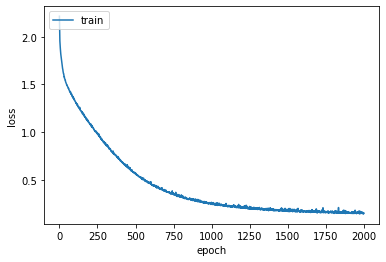

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc = 'upper left')
plt.show()

## Evaluate the model

In [35]:
scores = model.evaluate(x_train, y_train)
print (f"{model.metrics_names[1]} : {scores[1]*100:.2f}%")

50/50 [==============================] - 0s 117us/step
accuracy : 92.00%


## Prediction

### One-step prediction

In [36]:
pred_out = model.predict(x_train)
print (f"one step prediction : {pred_out}")

one step prediction : [[2.00004966e-16 1.12778866e-37 5.73186543e-29 2.52970750e-07
  4.83503548e-25 1.04137916e-16 1.24280274e-15 1.83277230e-18
  9.96029139e-01 3.97065282e-03 2.23883011e-16 3.29060339e-22]
 [4.27619311e-12 9.98175740e-01 4.26194805e-04 1.40191152e-19
  4.45998332e-08 1.46142109e-11 9.59009890e-13 4.46603112e-29
  2.35634616e-06 1.39564229e-03 4.25778092e-13 1.43300367e-12]
 [1.83767501e-10 4.06736986e-20 1.41889432e-33 2.38488224e-33
  2.43166848e-34 1.77354215e-10 4.09230705e-10 9.99732077e-01
  9.16911813e-06 3.27560556e-09 2.58783548e-04 6.95873887e-14]
 [1.55805474e-15 1.03592718e-36 3.81208928e-26 1.27700069e-13
  4.11285678e-31 7.32069665e-16 1.27778452e-14 2.50797534e-08
  2.87342489e-01 7.12657571e-01 1.42998524e-16 2.97673079e-32]
 [1.05420073e-08 7.17533985e-05 2.53734506e-13 3.10779902e-10
  4.07153138e-08 2.24255974e-08 6.10150197e-09 9.12741198e-22
  2.21588630e-02 9.69818592e-01 7.09499751e-11 7.95065332e-03]
 [8.35592751e-15 6.15766950e-26 0.00000000e

In [37]:
max_pred_count = 50

seq_out = ['g8','e8','e4','f8']

for i in range(max_pred_count) : 
    idx = np.argmax(pred_out[i])
    seq_out.append(idx2code[idx])

print (f"one step prediction : {seq_out}")

one step prediction : ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'e8', 'f8', 'g8', 'g8', 'g4', 'g8', 'e8', 'e8', 'e8', 'f8', 'g4', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'e8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'g4', 'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']


In [46]:
for i in range(len(seq) ):
    print (seq[i] == seq_out[i], end=' ')

True True True True True True True False True True True True True True True True True True False True True True True True True True True True True True True False True True True True True True True False True True True True True True True True True True True True True True 

### full song prediction

In [47]:
seq_in = ['g8','e8','e4','f8']
seq_out = seq_in
seq_in = [code2idx[it] / float(max_idx_value) for it in seq_in]

for i in range(max_pred_count) : 
    sample_in = np.array(seq_in)
    sample_in = np.reshape(sample_in, (1,4))
    pred_out = model.predict(sample_in)

    idx = np.argmax(pred_out)
    seq_out.append(idx2code[idx])
    seq_in.append(idx / float(max_idx_value))
    seq_in.pop(0)

print (f"full song prediction :\n{seq_out}")

full song prediction :
['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8']


In [50]:
print ([ seq[i] == seq_out[i] for i in range(len(seq))].count(False))
print ([ seq[i] == seq_out[i] for i in range(len(seq))].count(True))

34
20
